In [47]:
import pandas as pd
from LSTMPredict import LSTMPredict
from modules import LSTM_Model
from modules import Agent,Model
import numpy as np
import torch
import pickle
device = "cuda" if torch.cuda.is_available() else "cpu"
import matplotlib.pyplot as plt
import seaborn as sns
import os
from preprocessing import Feature_Extractor, data_preprocessing


In [4]:
symbol = "MWG"

In [5]:
data = pd.read_csv(f'DataTraining/{symbol}.csv')

In [6]:
data.head()

,Date,Close,Open,High,Low
0,2014-07-15,4718.0,4718.0,4718.0,4718.0
1,2014-07-16,5044.0,5044.0,5044.0,5044.0
2,2014-07-17,5396.0,5396.0,5396.0,5396.0
3,2014-07-18,5749.0,5749.0,5749.0,5749.0
4,2014-07-21,5749.0,6128.0,6128.0,5478.0


In [33]:
model = LSTM_Model(input_size = 20,output_size = 1)
model.to(device)
model.load_state_dict(torch.load(f"checkpoint/{symbol}_forecast_model.pt"))
x_scaler = pickle.load(open(f"checkpoint/{symbol}_LSTM_xscaler.pkl", 'rb'))
y_scaler = pickle.load(open(f"checkpoint/{symbol}_LSTM_yscaler.pkl", 'rb'))
result = LSTMPredict(data,x_scaler,y_scaler,model)

d:\KLTN\RLServer\LSTMPredict.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  update_row['Date']= update_row['Date'] + timedelta(days=1)
d:\KLTN\RLServer\LSTMPredict.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_feedback['Open'][update_index] = update_row['Open']
d:\KLTN\RLServer\LSTMPredict.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_feedback['High'][update_index] = update_row['High']
d:\KLTN\RLServer\LSTMPre

2451 Date        2024-05-10 00:00:00
Close                   58900.0
Open                    58800.0
High                    59000.0
Low                     57400.0
forecast                    NaN
signal                      NaN
Name: 2451, dtype: object
2452 {'Date': Timestamp('2024-05-11 00:00:00'), 'forecast': 58698.355}
2453 {'Date': Timestamp('2024-05-12 00:00:00'), 'forecast': 58905.15}
2454 {'Date': Timestamp('2024-05-13 00:00:00'), 'forecast': 58294.395}
2455 {'Date': Timestamp('2024-05-14 00:00:00'), 'forecast': 54764.168}
2456 {'Date': Timestamp('2024-05-15 00:00:00'), 'forecast': 56947.598}
2457 {'Date': Timestamp('2024-05-16 00:00:00'), 'forecast': 57403.79}
2458 {'Date': Timestamp('2024-05-17 00:00:00'), 'forecast': 57577.14}
2459 {'Date': Timestamp('2024-05-18 00:00:00'), 'forecast': 56574.95}
2460 {'Date': Timestamp('2024-05-19 00:00:00'), 'forecast': 54850.94}
2461 {'Date': Timestamp('2024-05-20 00:00:00'), 'forecast': 52990.418}
2462 {'Date': Timestamp('2024-05-21 00:0

In [34]:
result['Close'] = result['Close'].fillna(result['forecast'])

In [35]:
result.tail

<bound method NDFrame.tail of            Date         Close    Open    High     Low      forecast  signal
0    2014-07-15   4718.000000  4718.0  4718.0  4718.0           NaN     NaN
1    2014-07-16   5044.000000  5044.0  5044.0  5044.0           NaN     NaN
2    2014-07-17   5396.000000  5396.0  5396.0  5396.0           NaN     NaN
3    2014-07-18   5749.000000  5749.0  5749.0  5749.0           NaN     NaN
4    2014-07-21   5749.000000  6128.0  6128.0  5478.0           NaN     NaN
...         ...           ...     ...     ...     ...           ...     ...
2476 2024-06-04  58311.664062     NaN     NaN     NaN  58311.664062     NaN
2477 2024-06-05  61448.789062     NaN     NaN     NaN  61448.789062     NaN
2478 2024-06-06  64275.164062     NaN     NaN     NaN  64275.164062     NaN
2479 2024-06-07  67556.070312     NaN     NaN     NaN  67556.070312     NaN
2480 2024-06-08  70458.367188     NaN     NaN     NaN  70458.367188     NaN

[2481 rows x 7 columns]>

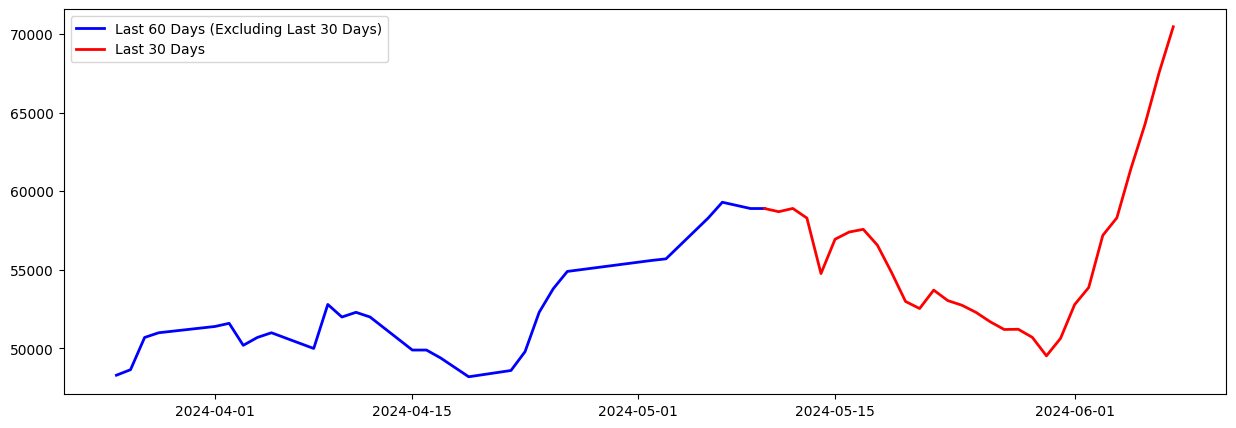

In [36]:
fig = plt.figure(figsize = (15, 5))
# Vẽ 60 ngày cuối cùng
plt.plot(result['Date'].iloc[-60:-29], result['Close'].iloc[-60:-29], color='blue', lw=2, label='Last 60 Days (Excluding Last 30 Days)')

# Vẽ 30 ngày cuối cùng với màu khác
plt.plot(result['Date'].iloc[-30:], result['Close'].iloc[-30:], color='red', lw=2, label='Last 30 Days')
plt.legend()
plt.show()

In [41]:
result = result.drop(columns=['forecast', 'signal'], errors='ignore')
output_directory = "LSTMCSV"
output_file_path = os.path.join(output_directory, "predictions.csv")
result.to_csv(output_file_path, index=False)

Start Trading

In [43]:
df = pd.read_csv(f'DataTraining/{symbol}.csv')

In [45]:
df.tail

<bound method NDFrame.tail of             Date    Close     Open     High      Low
0     2014-07-15   4718.0   4718.0   4718.0   4718.0
1     2014-07-16   5044.0   5044.0   5044.0   5044.0
2     2014-07-17   5396.0   5396.0   5396.0   5396.0
3     2014-07-18   5749.0   5749.0   5749.0   5749.0
4     2014-07-21   5749.0   6128.0   6128.0   5478.0
...          ...      ...      ...      ...      ...
2468  2024-06-04  63800.0  64000.0  64200.0  63100.0
2469  2024-06-05  62000.0  63000.0  63300.0  61600.0
2470  2024-06-06  61900.0  62000.0  62500.0  61600.0
2471  2024-06-07  62100.0  62300.0  62800.0  61800.0
2472  2024-06-10  63000.0  62200.0  63300.0  62000.0

[2473 rows x 5 columns]>

Trade without LSTM

In [111]:
df['Date'] = pd.to_datetime(df['Date'])
df_init = df[['Close']]  
df_init = data_preprocessing(df_init, Feature_Extractor)
real_trend = df_init['Close'].tolist()
parameters = [df_init[cl].tolist() for cl in df_init.columns]
minmax = pickle.load(open(f"checkpoint/{symbol}_scaler.pkl", 'rb'))
scaled_parameters = minmax.transform(np.array(parameters).T).T.tolist()
with open(f"checkpoint/{symbol}_model.pkl", 'rb') as fopen:
    model = pickle.load(fopen)
initial_money = np.max(parameters[0]) * 5
skip = 1
from_date ="2024-05-2"
to_date = "2024-06-10"
from_date = pd.to_datetime(from_date)
to_date = pd.to_datetime(to_date)
df = df[['Date', 'Close']]
#Preprocess Dataframe
df = data_preprocessing(df, Feature_Extractor)
selected_data = df.loc[(df['Date'] >= from_date) & (df['Date'] <= to_date),:]
data_list = selected_data.values.tolist()

In [112]:
agent = Agent(model = model,
                timeseries = scaled_parameters,
                skip = skip,
                initial_money = initial_money,
                real_trend = real_trend,
                minmax = minmax,
                window_size= 10)

In [113]:
trade_results = []
for row in data_list:
    #ensure first column is Date
    date = row[0]
    value = row[1:]
    result = agent.trade(value, date = date)
    trade_results.append(result)

[1. 0. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 0. 1.]
[2.02120642e-25 0.00000000e+00 1.00000000e+00]
[0. 0. 1.]
[0. 1. 0.]
[0. 1. 0.]
[0. 0. 1.]
[0. 0. 1.]
[1. 0. 0.]
[0. 0. 1.]
[1. 0. 0.]
[1. 0. 0.]
[0. 1. 0.]
[0. 0. 1.]
[0. 1. 0.]


In [114]:
result = pd.DataFrame(trade_results)

# Convert the 'date' column to datetime format
result['date'] = pd.to_datetime(result['date'])

In [115]:
total_gain = result['gain'].sum()
total_investment = result['investment'].sum()

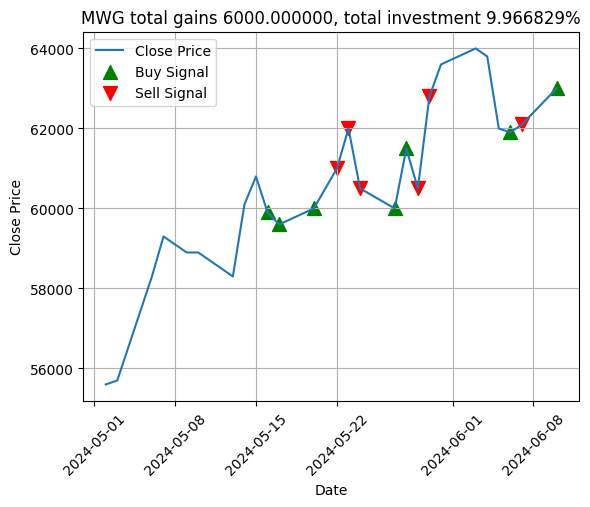

In [116]:

# Mark buy and sell actions
buy_signals = result[result['action'] == 1]
sell_signals = result[result['action'] == 2]
plt.plot(result['date'], result['close'], linestyle='-', label='Close Price')

plt.scatter(buy_signals['date'], buy_signals['close'], marker='^', color='g', s=100, label='Buy Signal')
plt.scatter(sell_signals['date'], sell_signals['close'], marker='v', color='r', s=100, label='Sell Signal')

# Customize the plot
plt.title('MWG total gains %f, total investment %f%%'%(total_gain, total_investment))
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

# Show the plot
plt.show()

In [67]:
print(trade_results)

[{'status': 'data not enough to trade', 'action': 0, 'close': 58900.0, 'balance': 397910.0, 'timestamp': '2024-06-10 19:13:57.506344', 'date': '2024-05-10'}, {'status': 'data not enough to trade', 'action': 0, 'close': 58300.0, 'balance': 397910.0, 'timestamp': '2024-06-10 19:13:57.506344', 'date': '2024-05-13'}, {'status': 'data not enough to trade', 'action': 0, 'close': 60100.0, 'balance': 397910.0, 'timestamp': '2024-06-10 19:13:57.507657', 'date': '2024-05-14'}, {'status': 'data not enough to trade', 'action': 0, 'close': 60800.0, 'balance': 397910.0, 'timestamp': '2024-06-10 19:13:57.507657', 'date': '2024-05-15'}, {'status': 'data not enough to trade', 'action': 0, 'close': 59900.0, 'balance': 397910.0, 'timestamp': '2024-06-10 19:13:57.507657', 'date': '2024-05-16'}, {'status': 'data not enough to trade', 'action': 0, 'close': 59600.0, 'balance': 397910.0, 'timestamp': '2024-06-10 19:13:57.508658', 'date': '2024-05-17'}, {'status': 'data not enough to trade', 'action': 0, 'clos

In [73]:
gain =499.99999999998545+1300+200.00000000000728
invest= 0.8333333333333088+2.113821138211382+0.3231017770597856

In [74]:
print(gain)
print(invest)

1999.9999999999927
3.2702562486044764


With LSTM

In [117]:
df['Date'] = pd.to_datetime(df['Date'])
df_init = df[['Close']]  
df_init = data_preprocessing(df_init, Feature_Extractor)
real_trend = df_init['Close'].tolist()
parameters = [df_init[cl].tolist() for cl in df_init.columns]
minmax = pickle.load(open(f"checkpoint/{symbol}predictions_scaler.pkl", 'rb'))
scaled_parameters = minmax.transform(np.array(parameters).T).T.tolist()
with open(f"checkpoint/{symbol}predictions_model.pkl", 'rb') as fopen:
    model = pickle.load(fopen)
initial_money = np.max(parameters[0]) * 5
skip = 1
from_date ="2024-05-2"
to_date = "2024-06-10"
from_date = pd.to_datetime(from_date)
to_date = pd.to_datetime(to_date)
df = df[['Date', 'Close']]
#Preprocess Dataframe
df = data_preprocessing(df, Feature_Extractor)
selected_data = df.loc[(df['Date'] >= from_date) & (df['Date'] <= to_date),:]
data_list = selected_data.values.tolist()

In [118]:
agent2 = Agent(model = model,
                timeseries = scaled_parameters,
                skip = skip,
                initial_money = initial_money,
                real_trend = real_trend,
                minmax = minmax,
                window_size= 10)

In [119]:
trade_results = []
for row in data_list:
    #ensure first column is Date
    date = row[0]
    value = row[1:]
    result = agent2.trade(value, date = date)
    trade_results.append(result)

[0. 0. 1.]
[0. 0. 1.]
[0. 1. 0.]
[0. 1. 0.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[1. 0. 0.]
[0. 1. 0.]
[0. 1. 0.]
[1. 0. 0.]
[0. 0. 1.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[0.00000000e+00 9.85914228e-04 9.99014086e-01]
[0. 1. 0.]
[0. 1. 0.]
[0. 0. 1.]


In [120]:
result = pd.DataFrame(trade_results)

# Convert the 'date' column to datetime format
result['date'] = pd.to_datetime(result['date'])
total_gain = result['gain'].sum()
total_investment = result['investment'].sum()

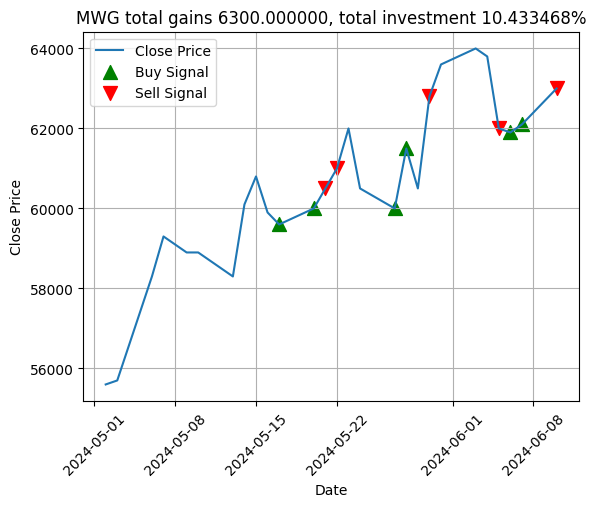

In [121]:
# Mark buy and sell actions
buy_signals = result[result['action'] == 1]
sell_signals = result[result['action'] == 2]
plt.plot(result['date'], result['close'], linestyle='-', label='Close Price')

plt.scatter(buy_signals['date'], buy_signals['close'], marker='^', color='g', s=100, label='Buy Signal')
plt.scatter(sell_signals['date'], sell_signals['close'], marker='v', color='r', s=100, label='Sell Signal')

# Customize the plot
plt.title('MWG total gains %f, total investment %f%%'%(total_gain, total_investment))
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

# Show the plot
plt.show()